In [1]:
# Following code is copied from the documentation for the dataset being used
# Dataset and documentation: https://dev.socrata.com/foundry/data.lacity.org/9yda-i4ya
# To run this API request, please pip install sodapy
# Import required libraries
import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.lacity.org", None)

# All results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9yda-i4ya", limit = 60000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Preview of the data
results_df.head()

,building_address,building_id,compliance,postal_code,program_year,apn,building_programclass,total_ghg_emissions,percent_difference_2,percent_difference_1,...,number_of_buildings,occupancy,outdoor_water_use,primary_property_1,site_eui,source_eui,water_use,weather_normalized_3,weather_normalized_4,year_built
0,14558 KESWICK ST,425463899040,NOT COMPLIED,91405,2021,028,"20,000 to 49,999 sqft",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5500 S FIGUEROA ST,476102819647,NOT COMPLIED,90037,2020,054,"20,000 to 49,999 sqft",138.1,29.5,29.5,...,1,100,Not Available,Multifamily Housing,54.7,99.9,2859.8,55.3,100.5,2001
2,11340 W OLYMPIC BLVD,427804836294,COMPLIED,90064,2020,017,"50,000 to 99,999 sqft",170.6,-47.8,-47.8,...,1,75,Not Available,Office,30.3,84.9,1052.3,Not Available,Not Available,1975
3,5650 FAIR AVE,448460885789,COMPLIED,91601,2021,011,"20,000 to 49,999 sqft",65.9,-27,-27,...,1,100,Not Available,Multifamily Housing,38.4,59.8,1.6,39.1,60.6,2010
4,4715 S ALAMEDA ST,488532822539,COMPLIED,90058,2021,011,"50,000 to 99,999 sqft",64.1,Not Available,Not Available,...,1,100,Not Available,Manufacturing/Industrial Plant,16.3,45.6,244.3,16.3,45.6,2007


In [2]:
# Create another dataframe to only include columns we would be using and drop rows with the NaN and "Not Available" values
results_clean_df = results_df.loc[:,['building_id', 'total_ghg_emissions', 'occupancy', 'primary_property_1', 'property_gfa_1', \
'water_use', 'weather_normalized_3', 'weather_normalized_4', 'year_built']]
results_NaN = results_clean_df.replace("Not Available", np.nan)
results = results_NaN.dropna()
results.head()

,building_id,total_ghg_emissions,occupancy,primary_property_1,property_gfa_1,water_use,weather_normalized_3,weather_normalized_4,year_built
1,476102819647,138.1,100,Multifamily Housing,44769,2859.8,55.3,100.5,2001
3,448460885789,65.9,100,Multifamily Housing,31030,1.6,39.1,60.6,2010
4,488532822539,64.1,100,Manufacturing/Industrial Plant,65000,244.3,16.3,45.6,2007
5,455587859077,33.5,100,Multifamily Housing,27777,837.1,20,40.3,1961
7,423570837725,24.2,100,Multifamily Housing,30095,1303.9,13.9,24.2,1960


In [3]:
# Change the data type to float for columns with number values
results_init= results.astype({'total_ghg_emissions': 'float',
                     'occupancy': 'float',
                     'property_gfa_1': 'float', 
                      'water_use': 'float',
                      'weather_normalized_3': 'float',
                      'weather_normalized_4': 'float',
                      'year_built': 'float'
                     })
# Remove buildings with 0 occupancy so we are only studying buildings that are occupied
results_final = results_init.loc[results_init["occupancy"] != 0]
results_final.head()

,building_id,total_ghg_emissions,occupancy,primary_property_1,property_gfa_1,water_use,weather_normalized_3,weather_normalized_4,year_built
1,476102819647,138.1,100.0,Multifamily Housing,44769.0,2859.8,55.3,100.5,2001.0
3,448460885789,65.9,100.0,Multifamily Housing,31030.0,1.6,39.1,60.6,2010.0
4,488532822539,64.1,100.0,Manufacturing/Industrial Plant,65000.0,244.3,16.3,45.6,2007.0
5,455587859077,33.5,100.0,Multifamily Housing,27777.0,837.1,20.0,40.3,1961.0
7,423570837725,24.2,100.0,Multifamily Housing,30095.0,1303.9,13.9,24.2,1960.0


In [4]:
# Get the count of buildings for each property type
property_types_counts = results_final.groupby(['primary_property_1'])['building_id'].count().sort_values(ascending = False)
property_types_counts

primary_property_1
Multifamily Housing                    12573
Office                                  3316
Manufacturing/Industrial Plant          1311
Non-Refrigerated Warehouse              1165
Self-Storage Facility                    659
                                       ...  
Urgent Care/Clinic/Other Outpatient        2
Convenience Store with Gas Station         2
Roller Rink                                1
Courthouse                                 1
Bureau                                     1
Name: building_id, Length: 76, dtype: int64

In [5]:
# Determine which property types have atleast 300 data points so the data is not affected by rarely occuring properties
keep_property_types = property_types_counts.loc[property_types_counts > 300]
keep_property_types = keep_property_types.drop(labels=['Other'])
keep_property_types = list(keep_property_types.index)
keep_property_types

['Multifamily Housing',
 'Office',
 'Manufacturing/Industrial Plant',
 'Non-Refrigerated Warehouse',
 'Self-Storage Facility',
 'Distribution Center',
 'Retail Store',
 'Fire Station',
 'Mixed Use Property',
 'Hotel',
 'Medical Office',
 'Parking']

In [6]:
# Create a new data frame with only highly frequent property types
buildings_initial = results_final.loc[results_clean_df['primary_property_1'].isin(keep_property_types)]
buildings_df = buildings_initial.rename(columns = {"weather_normalized_3":"WN_site_eui",
                                                   "weather_normalized_4":"WN_source_eui"
                                                  }
                                       )
buildings_df

,building_id,total_ghg_emissions,occupancy,primary_property_1,property_gfa_1,water_use,WN_site_eui,WN_source_eui,year_built
1,476102819647,138.1,100.0,Multifamily Housing,44769.0,2859.8,55.3,100.5,2001.0
3,448460885789,65.9,100.0,Multifamily Housing,31030.0,1.6,39.1,60.6,2010.0
4,488532822539,64.1,100.0,Manufacturing/Industrial Plant,65000.0,244.3,16.3,45.6,2007.0
5,455587859077,33.5,100.0,Multifamily Housing,27777.0,837.1,20.0,40.3,1961.0
7,423570837725,24.2,100.0,Multifamily Housing,30095.0,1303.9,13.9,24.2,1960.0
...,...,...,...,...,...,...,...,...,...
52578,487878840146,230.3,100.0,Multifamily Housing,105715.0,12530.6,37.8,75.1,1996.0
52579,481125799862,118.0,100.0,Multifamily Housing,69943.0,2476.1,29.1,55.7,2003.0
52580,379589902773,59.7,100.0,Multifamily Housing,28821.0,2283.1,36.6,68.3,1962.0
52581,410020916912,68.2,100.0,Multifamily Housing,21506.0,1468.4,57.4,105.0,1962.0


## Question 1: Which 5 property types have the highest correlation between water consumption and Carbon emissions, and source energy use and Carbon emissions?

In [7]:
# Make scatter plot and display linear regression line on plot
def linear_regress(x, y, xl, yl, text_coordinate):
    r = st.pearsonr(x, y)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y ={slope: .2f}x +{intercept: .2f}"
    plt.plot(x, regress_values, "r-")
    print(f"The r-value is: {r[0]}")
    plt.annotate(line_eq, text_coordinate, fontsize=12, color="red")
    plt.scatter(x, y)
    plt.xlabel(f"{xl}")
    plt.ylabel(f"{yl}")

In [8]:
# Create a DataFrame which shows the correlation between Carbon emissions and other varibales (Water Consumption and Source EUI). 
corr_df=buildings_df.groupby('primary_property_1')[['total_ghg_emissions', 'water_use', 'WN_source_eui']].corr()
corr_df=corr_df.reset_index()
corr_df.columns=['Property Type', 'x', 'Correlation with Carbon Emissions', 'Correlation with Water Consumption', 'Correlation with Source EUI']
corr_df

,Property Type,x,Correlation with Carbon Emissions,Correlation with Water Consumption,Correlation with Source EUI
0,Distribution Center,total_ghg_emissions,1.000000,0.039431,0.911813
1,Distribution Center,water_use,0.039431,1.000000,0.016375
2,Distribution Center,WN_source_eui,0.911813,0.016375,1.000000
3,Fire Station,total_ghg_emissions,1.000000,0.019279,0.837756
4,Fire Station,water_use,0.019279,1.000000,0.395135
5,Fire Station,WN_source_eui,0.837756,0.395135,1.000000
6,Hotel,total_ghg_emissions,1.000000,0.002078,0.291114
7,Hotel,water_use,0.002078,1.000000,-0.020709
8,Hotel,WN_source_eui,0.291114,-0.020709,1.000000
9,Manufacturing/Industrial Plant,total_ghg_emissions,1.000000,0.717306,0.511838


### Display Highly Correlated Property Types

##### Correlation of Water Use and Carbon Emissions 

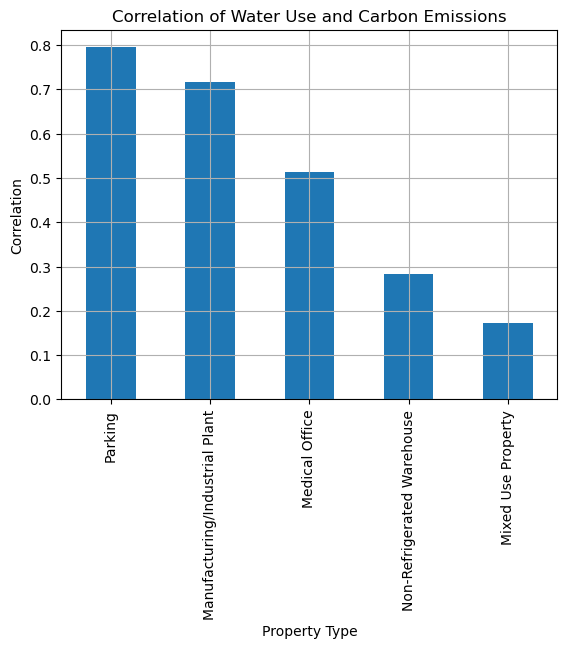

In [9]:
# Display the top highly correlated property types for water consumption vs. Carbon Dioxide Emissions
plot_df=corr_df[corr_df['x']=='water_use'][['Property Type', 'Correlation with Carbon Emissions']].sort_values(by=['Correlation with Carbon Emissions']
                                                                                                               , ascending = False)
plot_df[:5].plot(kind = 'bar', x = 'Property Type', y = 'Correlation with Carbon Emissions', ylabel = 'Correlation',
                 title = 'Correlation of Water Use and Carbon Emissions',  legend = False)
plt.grid()
plt.savefig('Figures/1A. Corr - Water vs Carbon.png', bbox_inches='tight')

##### Correlation of Energy Use and Carbon Emissions

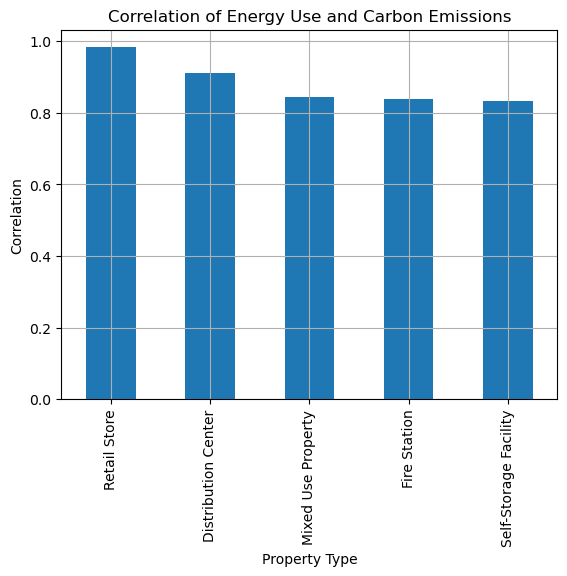

In [10]:
# Display the top highly correlated property types for source EUI vs. Carbon Dioxide Emissions
plot_df=corr_df[corr_df['x']=='WN_source_eui'][['Property Type', 'Correlation with Carbon Emissions']].sort_values(by=['Correlation with Carbon Emissions'], 
                                                                                                                   ascending = False)
plot_df[:5].plot(kind = 'bar',  x = 'Property Type', y = 'Correlation with Carbon Emissions', ylabel = 'Correlation', 
                 title = 'Correlation of Energy Use and Carbon Emissions', legend = False)
plt.grid()
plt.savefig('Figures/1B. Corr - Source EUI vs Carbon.png', bbox_inches='tight')

### Relationship between Water Use and Carbon Emissions for buildings that are parkings

In [11]:
# Create DataFrame for Plotting
water_plot_df = buildings_df.loc[buildings_df['primary_property_1'] == 'Parking', ["water_use", "total_ghg_emissions"]]
water_plot_df.head()

,water_use,total_ghg_emissions
191,98.0,29.2
491,631.4,90.3
621,1378.8,395.0
629,0.0,64.7
724,675.1,985.4


The r-value is: 0.794436164745564


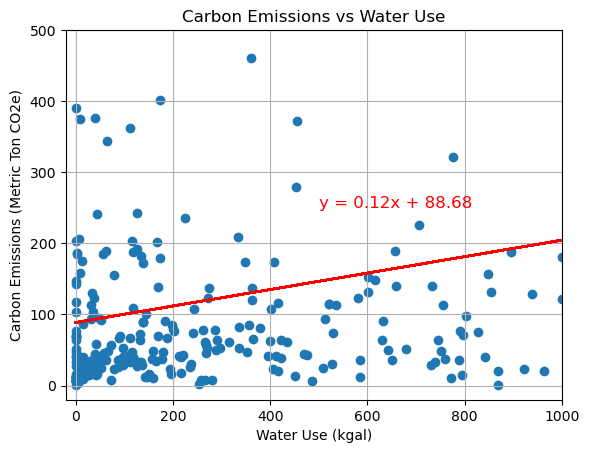

In [12]:
# Plotting 
linear_regress(water_plot_df['water_use'], water_plot_df['total_ghg_emissions'], "Water Use (kgal)", "Carbon Emissions (Metric Ton CO2e)", (500, 250))

# Closer snapshot
plt.xlim(-20, 1000)
plt.ylim(-20, 500)
plt.title('Carbon Emissions vs Water Use')
plt.grid()
plt.savefig('Figures/1C. Carbon vs Water for Parking.png', bbox_inches='tight')

**Findings:** For water use and carbon emissions, there appears to be a relatively strong positive correlation for Parking buildings, where the correlation coefficient between the two variables is 0.7173057056152874.

### Relationship between source energy use and Carbon Emissions for buildings that are retail stores

In [13]:
# Create DataFrame for Plotting
eui_plot_df = buildings_df.loc[buildings_df['primary_property_1'] == 'Retail Store', ["WN_source_eui", "total_ghg_emissions"]]
eui_plot_df.head()

,WN_source_eui,total_ghg_emissions
250,27.3,16.4
432,66.4,118.2
667,7.2,14.0
726,394.8,369.9
998,69.0,48.3


The r-value is: 0.9830449798002523


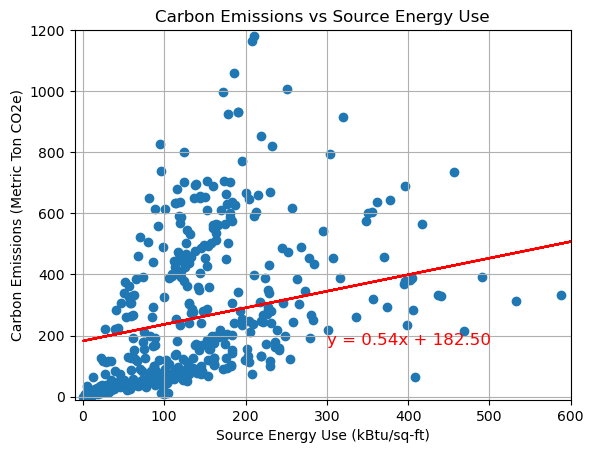

In [14]:
# Plotting 
linear_regress(eui_plot_df['WN_source_eui'], eui_plot_df['total_ghg_emissions'], "Source Energy Use (kBtu/sq-ft)", "Carbon Emissions (Metric Ton CO2e)", (300,170))

# Closer snapshot
plt.xlim(-10, 600)
plt.ylim(-10, 1200)
plt.title('Carbon Emissions vs Source Energy Use')
plt.grid()
plt.savefig('Figures/1D. Carbon vs Energy for Retail.png', bbox_inches='tight')

**Findings:** For source energy use and carbon emissions, there appears to be a very strong positive correlation for Retail Stores, where the correlation coefficient between the two variables is 0.9830449798002524.

## Question 2: What property type has highest source EUI consumption and water consumption per square foot for buildings built after 2000?

### Find and display water use for each building type

In [15]:
# Create another data frame to extract only columns we will need to find water use for each building type
water_per_gfa = buildings_df.loc[:, ["building_id", "primary_property_1", "water_use", "property_gfa_1","year_built" ]]
# Add another column to show water use per square foot
water_per_gfa["water usage per gfa"] = water_per_gfa["water_use"]/ water_per_gfa["property_gfa_1"]
water_per_gfa.head()

,building_id,primary_property_1,water_use,property_gfa_1,year_built,water usage per gfa
1,476102819647,Multifamily Housing,2859.8,44769.0,2001.0,0.063879
3,448460885789,Multifamily Housing,1.6,31030.0,2010.0,0.000052
4,488532822539,Manufacturing/Industrial Plant,244.3,65000.0,2007.0,0.003758
5,455587859077,Multifamily Housing,837.1,27777.0,1961.0,0.030136
7,423570837725,Multifamily Housing,1303.9,30095.0,1960.0,0.043326


In [16]:
# Filter the dataframe to show buildings built only after 2000
water_year = water_per_gfa.loc[water_per_gfa["year_built"]>2000,]
water_year.head()

,building_id,primary_property_1,water_use,property_gfa_1,year_built,water usage per gfa
1,476102819647,Multifamily Housing,2859.8,44769.0,2001.0,0.063879
3,448460885789,Multifamily Housing,1.6,31030.0,2010.0,0.000052
4,488532822539,Manufacturing/Industrial Plant,244.3,65000.0,2007.0,0.003758
27,999000000240,Multifamily Housing,4917.7,121379.0,2013.0,0.040515
45,427980806270,Multifamily Housing,6646.3,183174.0,2004.0,0.036284


In [17]:
# Determine the water use for each building type and print the property type with the highest water use per sq-ft
water_use_max = water_year.groupby("primary_property_1")["water_use"].median().sort_values(ascending = False)
print(f"{water_use_max.index[0]} has the highest water consumption per sq-ft, with a value of {water_use_max[0]} kgal/sq-ft")

Hotel has the highest water consumption per sq-ft, with a value of 8115.6 kgal/sq-ft


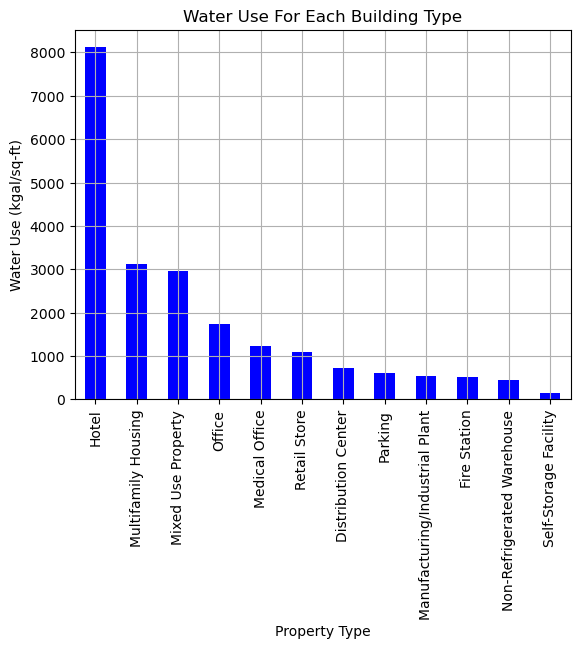

In [18]:
# Plot the water use for each building type
water_use_max.plot.bar(color='b')
plt.xlabel("Property Type")
plt.ylabel("Water Use (kgal/sq-ft)")
plt.title("Water Use For Each Building Type")
plt.savefig('Figures/2A. Water - Building Type.png', bbox_inches='tight')
plt.grid()
plt.show()

### Find and display energy use for each building type

In [19]:
# Create another data frame to extract only columns we will need to find energy use for each building type
eui_per_gfa = buildings_df.loc[:, ["building_id", "primary_property_1", "WN_source_eui", "property_gfa_1","year_built" ]]
eui_per_gfa.head()

,building_id,primary_property_1,WN_source_eui,property_gfa_1,year_built
1,476102819647,Multifamily Housing,100.5,44769.0,2001.0
3,448460885789,Multifamily Housing,60.6,31030.0,2010.0
4,488532822539,Manufacturing/Industrial Plant,45.6,65000.0,2007.0
5,455587859077,Multifamily Housing,40.3,27777.0,1961.0
7,423570837725,Multifamily Housing,24.2,30095.0,1960.0


In [20]:
# Filter the dataframe to show buildings built only after 2000
eui_year = eui_per_gfa.loc[eui_per_gfa["year_built"]>2000,]
eui_year.head()

,building_id,primary_property_1,WN_source_eui,property_gfa_1,year_built
1,476102819647,Multifamily Housing,100.5,44769.0,2001.0
3,448460885789,Multifamily Housing,60.6,31030.0,2010.0
4,488532822539,Manufacturing/Industrial Plant,45.6,65000.0,2007.0
27,999000000240,Multifamily Housing,61.5,121379.0,2013.0
45,427980806270,Multifamily Housing,61.5,183174.0,2004.0


In [21]:
# Determine the energy use intensity for each building type and print the property type with the highest energy use intensity
eui_use_max = eui_year.groupby("primary_property_1")["WN_source_eui"].median().sort_values(ascending = False)
print(f"{eui_use_max.index[0]} has the highest water consumption per sq-ft, with a value of {eui_use_max[0]} kgal/sq-ft")

Medical Office has the highest water consumption per sq-ft, with a value of 168.6 kgal/sq-ft


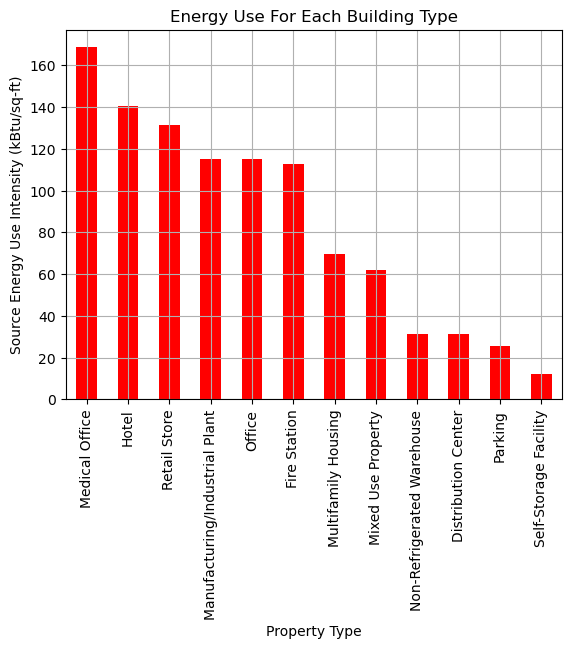

In [22]:
# Plot the energy use for each building type
eui_use_max.plot.bar(color='r')
plt.xlabel("Property Type")
plt.ylabel("Source Energy Use Intensity (kBtu/sq-ft)")
plt.title("Energy Use For Each Building Type")
plt.savefig('Figures/2A. Energy - Building Type.png', bbox_inches='tight')
plt.grid()
plt.show()

## Question 3: Does any property type have a correlation between water use and gross building floor area, and if there is a correlation, what is the relationship between water use and gross building floor area for that building type?

### Find the correlation between Building Floor Area and its Water Use for different Building Types

In [23]:
# Find the correlation between water use and gross building floor area for different building types
corr_gfa_water = buildings_df.groupby(by = 'primary_property_1')['property_gfa_1'].corr(buildings_df['water_use']).sort_values(ascending = False)
corr_gfa_water

primary_property_1
Mixed Use Property                0.537489
Manufacturing/Industrial Plant    0.521594
Medical Office                    0.509829
Self-Storage Facility             0.135871
Parking                           0.116855
Non-Refrigerated Warehouse        0.099166
Office                            0.059833
Distribution Center               0.042327
Hotel                             0.017883
Multifamily Housing               0.003693
Retail Store                     -0.035485
Fire Station                     -0.038014
Name: property_gfa_1, dtype: float64

In [24]:
# Print the building type with the highest correlation between water use and gross builidng floor area
print(f"{corr_gfa_water.index[0]} has highest correlation between water use and groos building floor area, with a correlation value of {corr_gfa_water[0]}")

Mixed Use Property has highest correlation between water use and groos building floor area, with a correlation value of 0.5374894286405508


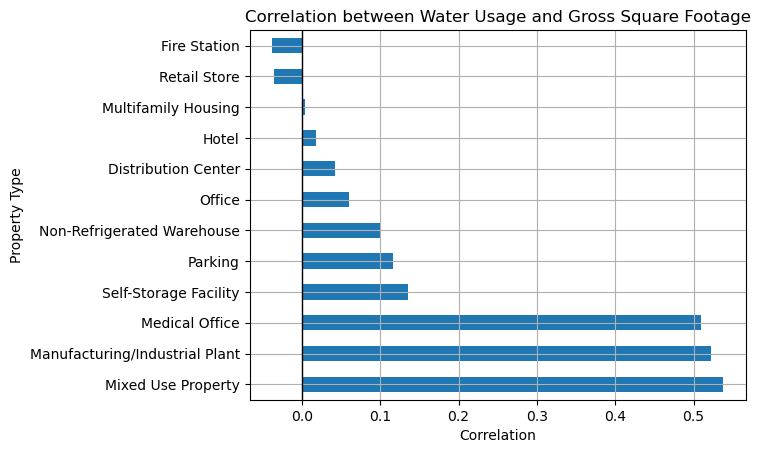

In [25]:
# Plot the correlation values for different building types
fig = corr_gfa_water.plot.barh(x = corr_gfa_water, y = corr_gfa_water.index)
plt.xlabel("Correlation")
plt.ylabel("Property Type")
plt.axvline(x = 0, color = 'black', linewidth = 1)
plt.title("Correlation between Water Usage and Gross Square Footage")
plt.savefig('Figures/3A. Corr - Water vs GFA.png', bbox_inches='tight')
plt.grid()
plt.show()

Since "Mixed Use" properties can vary signifcantly in use, and it is hard to draw conclusions, we shall study Manufacturing/Industrial Plants instead.

### Display the relationship between Gross Building Floor Area and Water Use for Manufacturing/Indsutrial Plants

The r-value is: 0.5215937191397046


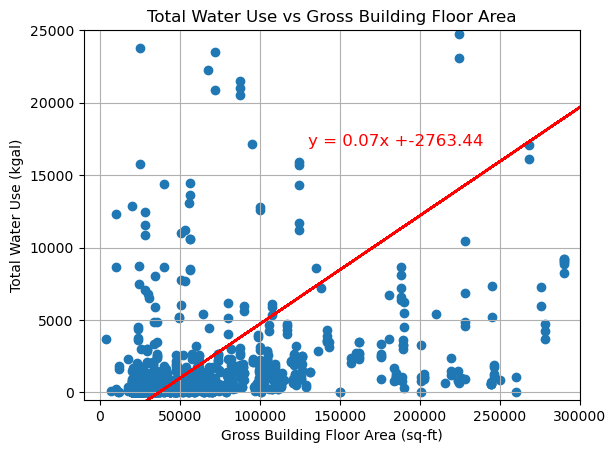

In [26]:
# Plot Gross Building Floor Area vs Water Use for Manufacturing/Indsutrial Plants
x = buildings_df.loc[buildings_df['primary_property_1']=='Manufacturing/Industrial Plant']['property_gfa_1']
y = buildings_df.loc[buildings_df['primary_property_1']=='Manufacturing/Industrial Plant']['water_use']
linear_regress(x, y, 'Gross Building Floor Area (sq-ft)', 'Total Water Use (kgal)', [0.13e6, 17000])
plt.ylim([-500, 25000])
plt.xlim([-0.01e6, 0.3e6])
plt.title('Total Water Use vs Gross Building Floor Area')
plt.savefig('Figures/3B. Water vs GFA.png', bbox_inches='tight')
plt.grid()
plt.show()

**Findings:** For water use and gross building floor area, there appears to be a moderately strong positive correlation for Manufacturing/Industrial Plants, where the correlation coefficient between the two variables is 0.5215937191397046.

## Question 4: For multi-family housing building type, is there a relationship between year built and source EUI, as well as year built water consumption per square foot?

### Create a dataframe that has bins based on the decade the building was built

In [27]:
# Create bins for year built column
bins = [0, 1960, 1970, 1980, 1990, 2000, 2010, 2023]
labels = ['<1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','>2010']
buildings_4_df = buildings_df
buildings_4_df['binned'] = pd.cut(buildings_4_df['year_built'], bins=bins, labels=labels)
buildings_4_df

,building_id,total_ghg_emissions,occupancy,primary_property_1,property_gfa_1,water_use,WN_site_eui,WN_source_eui,year_built,binned
1,476102819647,138.1,100.0,Multifamily Housing,44769.0,2859.8,55.3,100.5,2001.0,2000-2010
3,448460885789,65.9,100.0,Multifamily Housing,31030.0,1.6,39.1,60.6,2010.0,2000-2010
4,488532822539,64.1,100.0,Manufacturing/Industrial Plant,65000.0,244.3,16.3,45.6,2007.0,2000-2010
5,455587859077,33.5,100.0,Multifamily Housing,27777.0,837.1,20.0,40.3,1961.0,1960-1970
7,423570837725,24.2,100.0,Multifamily Housing,30095.0,1303.9,13.9,24.2,1960.0,<1960
...,...,...,...,...,...,...,...,...,...,...
52578,487878840146,230.3,100.0,Multifamily Housing,105715.0,12530.6,37.8,75.1,1996.0,1990-2000
52579,481125799862,118.0,100.0,Multifamily Housing,69943.0,2476.1,29.1,55.7,2003.0,2000-2010
52580,379589902773,59.7,100.0,Multifamily Housing,28821.0,2283.1,36.6,68.3,1962.0,1960-1970
52581,410020916912,68.2,100.0,Multifamily Housing,21506.0,1468.4,57.4,105.0,1962.0,1960-1970


In [28]:
# Create a column where the value is water use divided by property gross footage area
buildings_4_df["water_per_gfa"] = buildings_4_df["water_use"]/buildings_4_df["property_gfa_1"]

In [29]:
# Filter dataframe by Multifamily housing
filter_buildings_df = buildings_4_df.loc[buildings_4_df['primary_property_1']== 'Multifamily Housing']
filter_buildings_df

,building_id,total_ghg_emissions,occupancy,primary_property_1,property_gfa_1,water_use,WN_site_eui,WN_source_eui,year_built,binned,water_per_gfa
1,476102819647,138.1,100.0,Multifamily Housing,44769.0,2859.8,55.3,100.5,2001.0,2000-2010,0.063879
3,448460885789,65.9,100.0,Multifamily Housing,31030.0,1.6,39.1,60.6,2010.0,2000-2010,0.000052
5,455587859077,33.5,100.0,Multifamily Housing,27777.0,837.1,20.0,40.3,1961.0,1960-1970,0.030136
7,423570837725,24.2,100.0,Multifamily Housing,30095.0,1303.9,13.9,24.2,1960.0,<1960,0.043326
10,476021805520,65.5,100.0,Multifamily Housing,30214.0,1201.4,34.6,68.5,1998.0,1990-2000,0.039763
...,...,...,...,...,...,...,...,...,...,...,...
52578,487878840146,230.3,100.0,Multifamily Housing,105715.0,12530.6,37.8,75.1,1996.0,1990-2000,0.118532
52579,481125799862,118.0,100.0,Multifamily Housing,69943.0,2476.1,29.1,55.7,2003.0,2000-2010,0.035402
52580,379589902773,59.7,100.0,Multifamily Housing,28821.0,2283.1,36.6,68.3,1962.0,1960-1970,0.079217
52581,410020916912,68.2,100.0,Multifamily Housing,21506.0,1468.4,57.4,105.0,1962.0,1960-1970,0.068279


### Group the data for multi-family housing by the decade when it was built and use median values to describe water usage and energy use intensity

In [30]:
# Calculating median for each bin so that median could be used to describe each bin
groups = filter_buildings_df.groupby('binned').median()
groups

,total_ghg_emissions,occupancy,property_gfa_1,water_use,WN_site_eui,WN_source_eui,year_built,water_per_gfa
binned,,,,,,,,
<1960,78.25,100.0,32400.0,1893.3,43.20,71.4,1930.0,0.052739
1960-1970,77.10,100.0,33023.0,2004.8,39.60,71.6,1964.0,0.055974
1970-1980,87.40,100.0,39880.0,2216.5,37.40,69.6,1974.0,0.051643
1980-1990,84.20,100.0,39876.0,1985.3,36.20,68.7,1987.0,0.045253
1990-2000,89.90,100.0,42267.0,2531.4,36.10,69.0,1995.0,0.051329
2000-2010,146.10,100.0,73456.0,3031.1,37.30,70.7,2006.0,0.039323
>2010,205.20,100.0,93587.5,3215.9,34.05,67.1,2014.0,0.032714


In [31]:
# Double check that using the median for the bins is a good idea by ensuring each bin has sufficient data points
counts = filter_buildings_df.groupby('binned')['building_id'].count()
for i in range(len(counts)):
    if counts[i] < 100:
        print(f'Not enough data points for {counts[i]}')
    else:
        print(f'Enough data points are available for {counts.index[i]}.')

Enough data points are available for <1960.
Enough data points are available for 1960-1970.
Enough data points are available for 1970-1980.
Enough data points are available for 1980-1990.
Enough data points are available for 1990-2000.
Enough data points are available for 2000-2010.
Enough data points are available for >2010.


### Display the trends for water use and energy use intensity

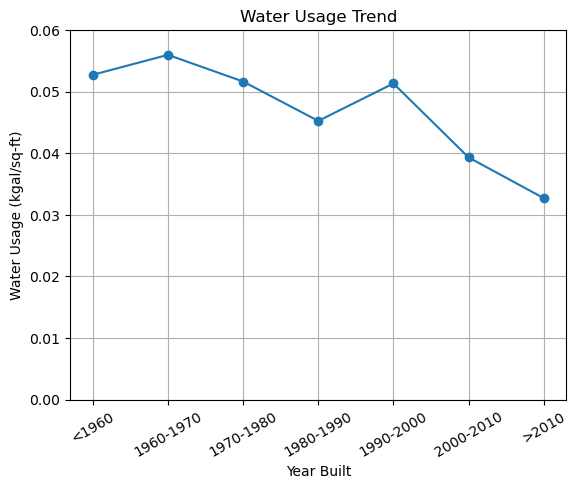

In [32]:
# Plot Water Use Trend
groups['water_per_gfa'].plot.line(style='o-')
plt.xlabel("Year Built")
plt.ylabel("Water Usage (kgal/sq-ft)")
plt.ylim([0, 0.06])
plt.xticks(rotation=30)
plt.grid()
plt.title("Water Usage Trend")
plt.savefig('Figures/4A. Water per Decade.png', bbox_inches='tight')
plt.show()

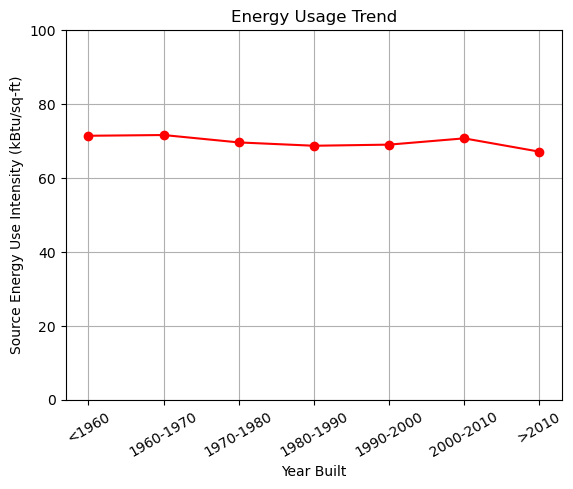

In [34]:
# Plot Energy Use Trend
groups['WN_source_eui'].plot.line(style='o-', color = 'r')
plt.xlabel("Year Built")
plt.ylabel("Source Energy Use Intensity (kBtu/sq-ft)")
plt.ylim([0,100])
plt.xticks(rotation=30)
plt.grid()
plt.title("Energy Usage Trend")
plt.savefig('Figures/4B. Energy per Decade.png', bbox_inches='tight')
plt.show()

**Findings:** Based on the above trendlines, it seems like the water usage intensity has decreased with year the property was built, however, no such trend is observed for energy use intensity.